In [1]:
# Import the relevant modules
import pandas as pd
import sklearn as sk
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib as mpl

import torch as torch
import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import pytorch_lightning.callbacks as callbacks
import torch_geometric as tg
from torch_geometric.utils import to_networkx
from torchsummary import summary
from torch_geometric.nn import SAGEConv, GraphNorm, GATConv, GINConv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.mixture import GaussianMixture

import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy.stats import gaussian_kde
from torch_geometric.data import InMemoryDataset, Data
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [2]:
class StellarGraphDataset(InMemoryDataset):
    def __init__(self, root, data_list, transform=None, pre_transform=None):
        super(StellarGraphDataset, self).__init__(root, transform, pre_transform)
        self.graph_data_list = data_list
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        if self.graph_data_list is not None:
            data_list = self.graph_data_list
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])

# Assuming graph_data_list is your list of torch_geometric.data.Data objects
class StellarGraphDataset(InMemoryDataset):
    def __init__(self, root, data_list=None, transform=None, pre_transform=None):
        self.data_list = data_list
        super(StellarGraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        if self.data_list is not None:
            data, slices = self.collate(self.data_list)
            torch.save((data, slices), self.processed_paths[0])


In [3]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y, categoric_values):
    mi_scores = mutual_info_regression(X,y, discrete_features = categoric_values)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores,cmap = "autumn"):
    scores = scores.sort_values(ascending = False)
    graphic =  sns.heatmap(data = pd.DataFrame(scores.values.reshape(-1,1), index = scores.index),  annot = True, cbar = True, cmap = cmap)
    plt.title("Mutual Informarion Scores")
    plt.show()

In [4]:
Stellar_Dataset = StellarGraphDataset(root= r"C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\Machine Learning Personal Projects\StellarRegression")

In [5]:
Dataset = pd.read_csv("Stellar_Dataset2.csv")
Dataset.drop(columns = ["SOURCE_ID"], inplace = True)
Dataset.dropna(inplace = True)
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ra                 200000 non-null  float64
 1   dec                200000 non-null  float64
 2   parallax           200000 non-null  float64
 3   pmra               200000 non-null  float64
 4   pmdec              200000 non-null  float64
 5   phot_g_mean_mag    200000 non-null  float64
 6   phot_bp_mean_mag   200000 non-null  float64
 7   phot_rp_mean_mag   200000 non-null  float64
 8   teff_gspphot       200000 non-null  float64
 9   logg_gspphot       200000 non-null  float64
 10  distance_gspphot   200000 non-null  float64
 11  ag_gspphot         200000 non-null  float64
 12  azero_gspphot      200000 non-null  float64
 13  mh_gspphot         200000 non-null  float64
 14  bp_rp              200000 non-null  float64
 15  bp_g               200000 non-null  float64
 16  g_

In [6]:
len(Dataset.drop(columns= ["age_flame", "evolstage_flame", "lum_flame"]).columns)

22

In [7]:
D_Train_Valid, D_Test = Stellar_Dataset[:int(len(Stellar_Dataset)*0.8)], Stellar_Dataset[int(len(Stellar_Dataset)*0.8):]
D_Train, D_Valid = train_test_split(D_Train_Valid, test_size=0.2)
len(D_Train), len(D_Valid), len(D_Test)

(4488, 1122, 1403)

In [8]:
i = 0
Train_Dataset = np.array([])
Target_Dataset = np.array([])
for index in range(len(D_Train)-1):
    X = D_Train[index].x.numpy()
    y = D_Train[index].y.numpy()
    Train_Dataset = np.concatenate((Train_Dataset, X), axis=0) if Train_Dataset.size else X
    Target_Dataset = np.concatenate((Target_Dataset, y), axis=0) if Target_Dataset.size else y
Train_Dataset = pd.DataFrame(Train_Dataset, columns = Dataset.drop(columns= ["age_flame", "evolstage_flame", "lum_flame"]).columns)
Train_Target_Dataset = pd.DataFrame(Target_Dataset, columns = ["age_flame", "evolstage_flame", "lum_flame"])

In [9]:
i = 0
Valid_Data_Dataset = np.array([])
Target_Dataset = np.array([])
for index in range(len(D_Valid)-1):
    X = D_Valid[index].x.numpy()
    y = D_Valid[index].y.numpy()
    Valid_Data_Dataset = np.concatenate((Valid_Data_Dataset, X), axis=0) if Valid_Data_Dataset.size else X
    Target_Dataset = np.concatenate((Target_Dataset, y), axis=0) if Target_Dataset.size else y
Valid_Dataset = pd.DataFrame(Train_Dataset, columns = Dataset.drop(columns= ["age_flame", "evolstage_flame", "lum_flame"]).columns)
Valid_Target_Dataset = pd.DataFrame(Target_Dataset, columns = ["age_flame", "evolstage_flame", "lum_flame"])

In [10]:
Data = pd.concat([Train_Dataset, Train_Target_Dataset], axis=1)
Data.head(5)

,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,teff_gspphot,logg_gspphot,...,bp_g,g_rp,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,radius_flame,mass_flame,age_flame,evolstage_flame,lum_flame
0,0.629523,1.241699,0.428075,-1.508273,-2.138194,1.044841,1.005791,1.031885,-0.738891,1.065068,...,0.259347,0.331149,-0.044173,-0.034651,-0.056404,-0.417434,-0.747247,7.988116,355.0,0.301222
1,0.642823,1.247989,1.615996,-1.377980,-1.940956,-0.812514,-0.885058,-0.735454,-0.104686,0.768092,...,-0.587995,-0.615727,-0.016348,-0.014121,-0.019808,-0.424394,-0.622091,12.022922,323.0,0.436170
2,0.480105,1.149463,0.658120,-1.474382,-2.065056,1.016618,0.859627,1.111119,-1.028476,0.944902,...,-0.194344,-0.250565,-0.044056,-0.034259,-0.056895,-0.467839,-0.834003,2.003734,141.0,0.113035
3,0.464314,1.144927,0.737148,-1.370467,-2.031510,0.305633,0.119461,0.438123,-0.415898,0.848154,...,-0.580112,-0.631916,-0.039319,-0.030558,-0.050916,-0.453387,-0.651479,0.975663,116.0,0.230235
4,0.460063,1.147546,0.625029,-1.462908,-2.054585,1.197931,1.031487,1.272041,-1.199590,1.063897,...,-0.159389,-0.096079,-0.044748,-0.034712,-0.057767,-0.467436,-0.879534,1.654246,138.0,0.098136


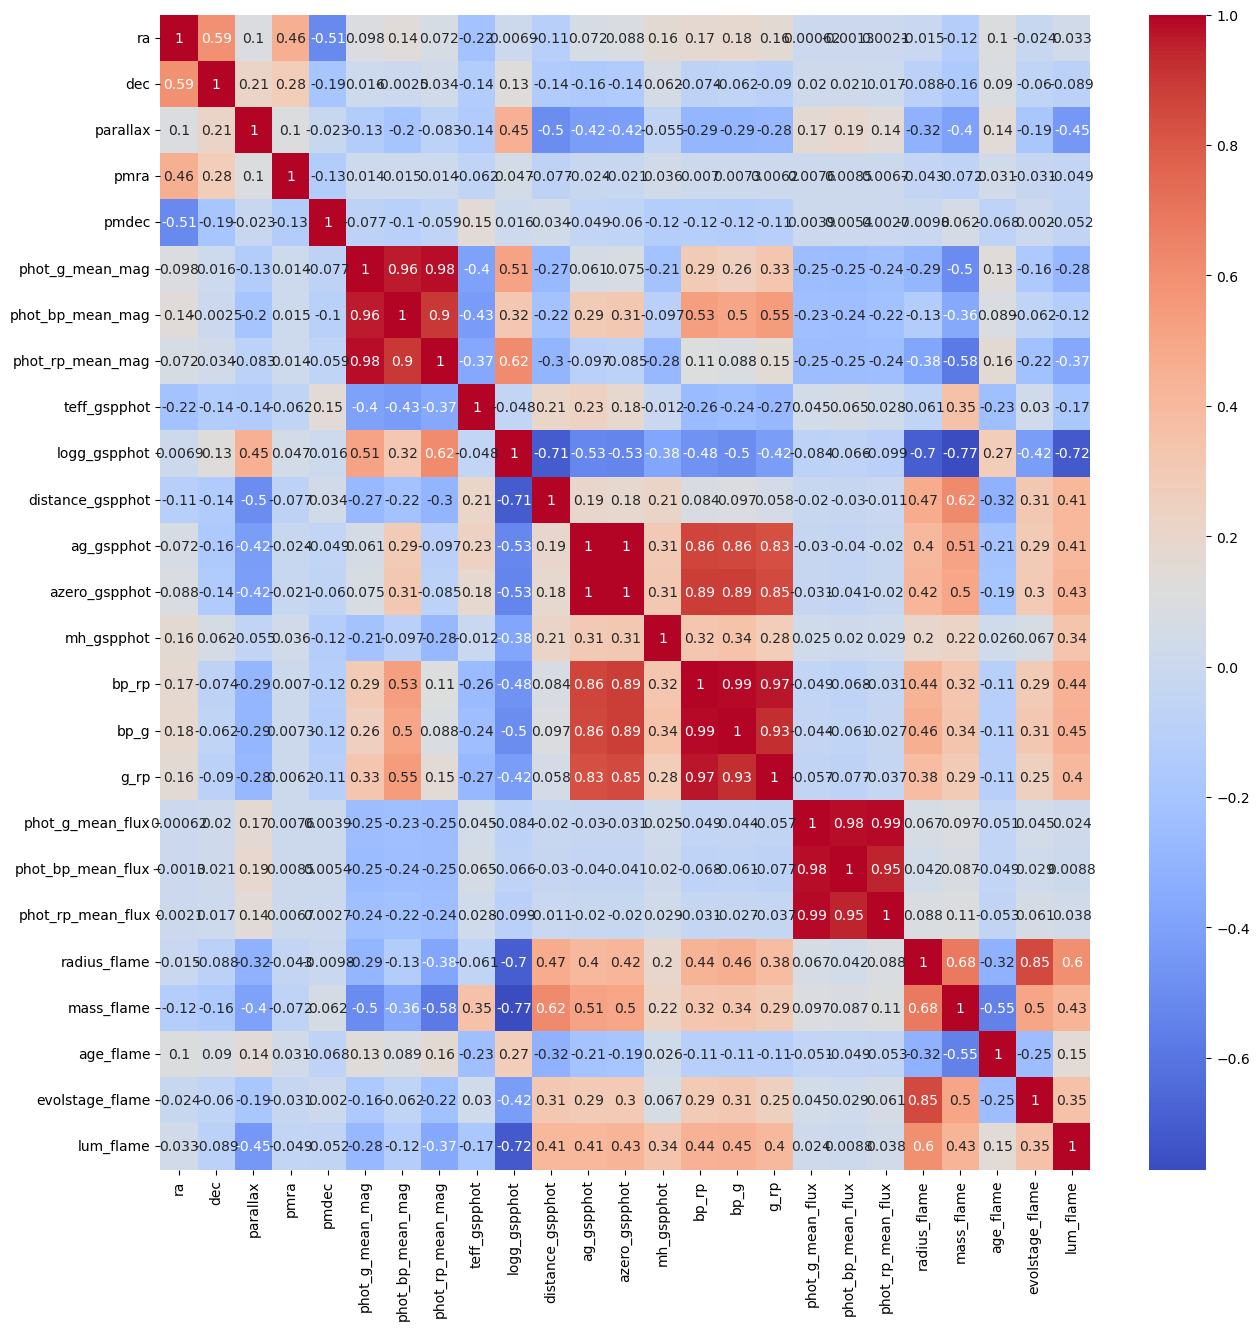

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(Data.corr(), annot = True, cmap = "coolwarm")  
plt.show()

In [ ]:
D_TrainLoader = data_utils.DataLoader(D_Train, batch_size=32, shuffle=True)
D_ValidLoader = data_utils.DataLoader(D_Valid, batch_size=32, shuffle=False)
D_TestLoader = data_utils.DataLoader(D_Test, batch_size=32, shuffle=False)

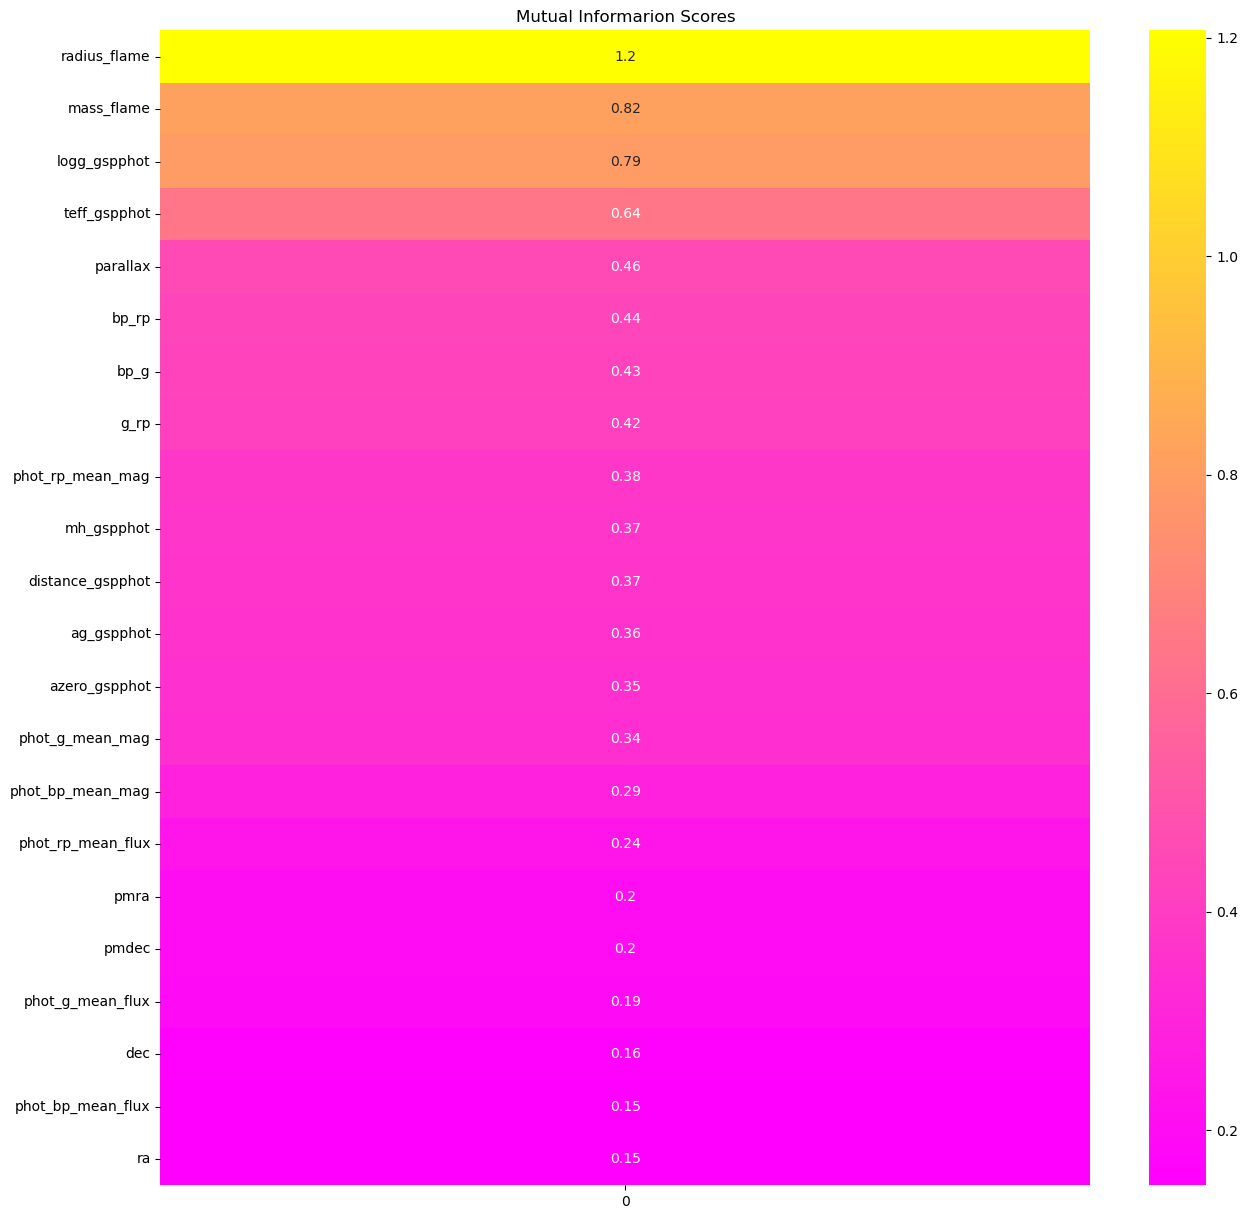

In [ ]:
plt.figure(figsize = (15,15))
lum_flame = make_mi_scores(Train_Dataset, Target_Dataset.lum_flame, "auto")
plot_mi_scores(lum_flame, cmap = "spring")
plt.show()

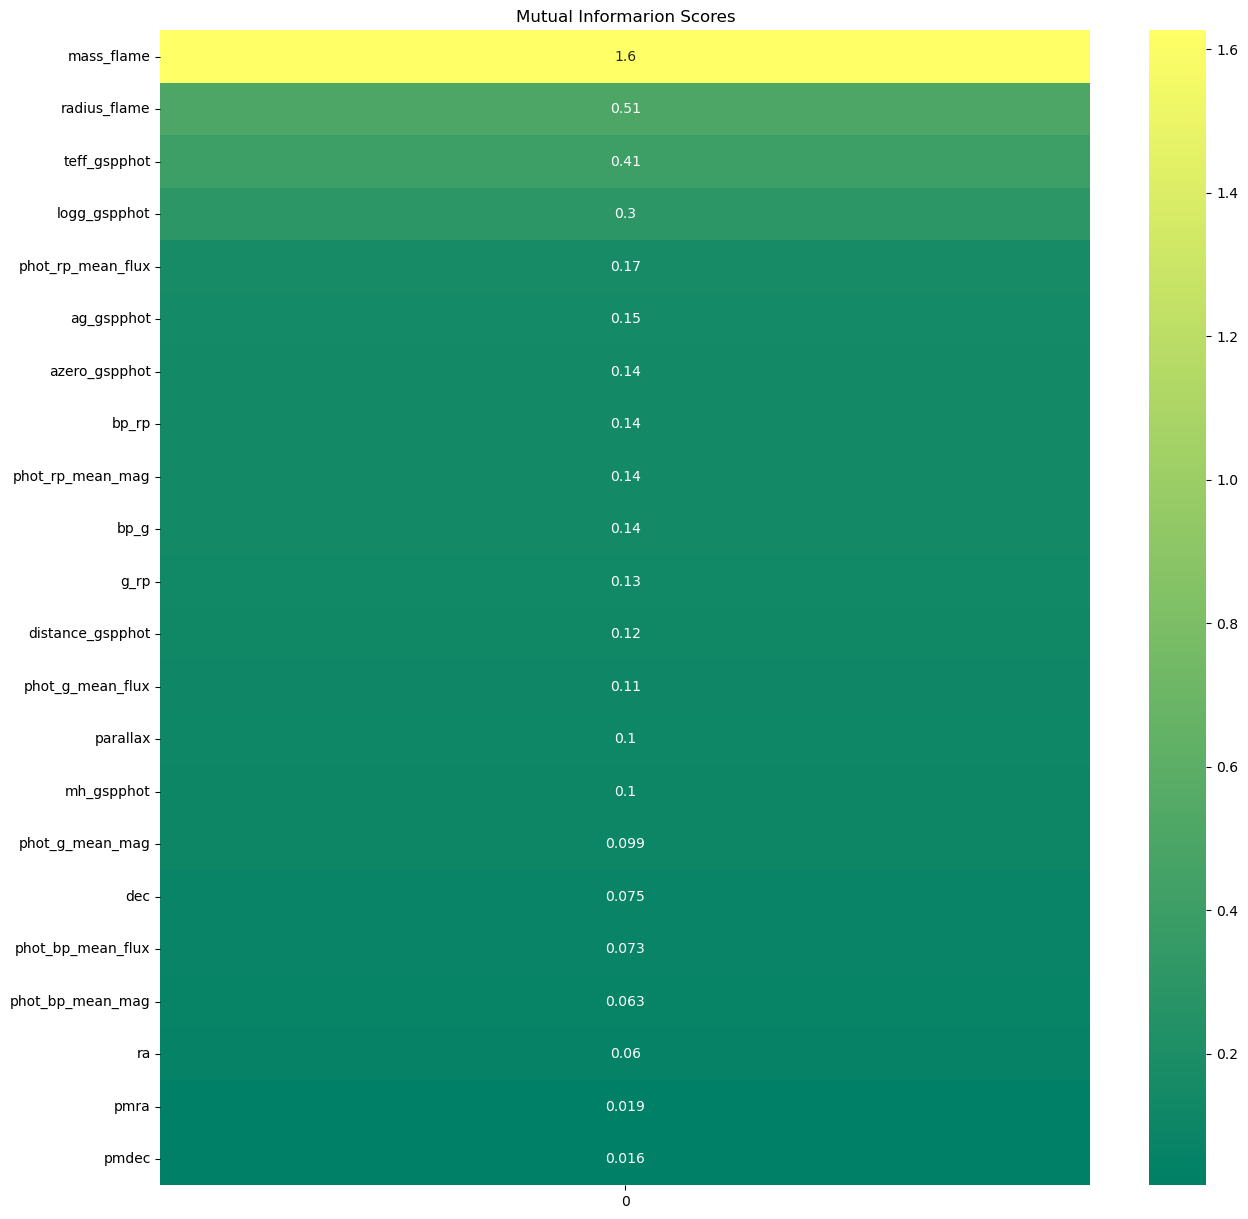

In [ ]:
plt.figure(figsize = (15,15))
age_flame = make_mi_scores(Train_Dataset, Target_Dataset.age_flame, "auto")
plot_mi_scores(age_flame, cmap = "summer")
plt.show()

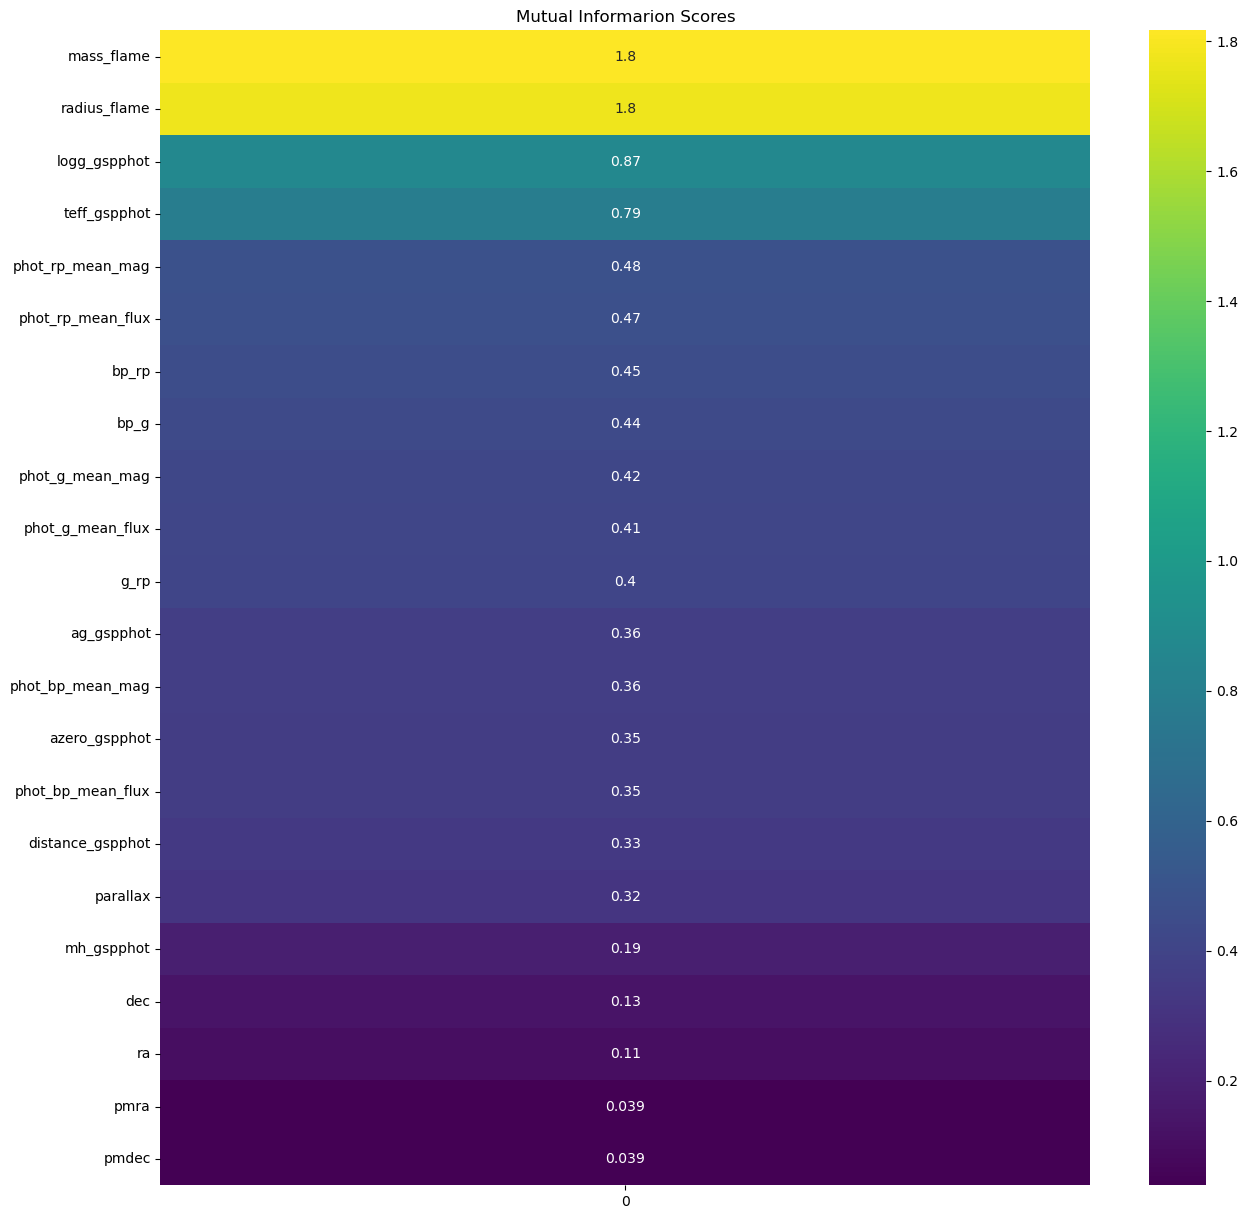

In [ ]:
plt.figure(figsize = (15,15))
evolstage_flame = make_mi_scores(Train_Dataset, Target_Dataset.evolstage_flame, "auto")
plot_mi_scores(evolstage_flame, cmap = "viridis")
plt.show()

In [12]:
class StellarGraphSage(L.LightningModule):
    def __init__(self, in_features, hidden_features, out_features):
        super(StellarGraphSage, self).__init__()
        self.conv1 = SAGEConv(in_features, hidden_features)
        self.conv2 = SAGEConv(hidden_features, hidden_features, normalize=False)
        self.conv3 = SAGEConv(hidden_features, hidden_features, normalize=False)
        self.GraphNorm_1 = GraphNorm(hidden_features)
        self.GraphNorm_2 = GraphNorm(hidden_features)
        self.GraphNorm_3 = GraphNorm(hidden_features)
        self.activation = nn.GELU()
        self.conv4 = SAGEConv(hidden_features, out_features)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = self.conv1(x, edge_index)
        x1 = self.GraphNorm_1(x1)
        x1 = self.activation(x1)

        x2 = self.conv2(x1, edge_index)
        x2 = self.GraphNorm_2(x2)
        x2 = self.activation(x2+x1)

        x3 = self.conv3(x2, edge_index)
        x3 = self.GraphNorm_3(x3)
        x3 = self.activation(x3+x2)
        
        x4 = self.conv4(x3, edge_index)
        return x4
    
    def training_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 0.01, weight_decay= 0.001)
    
    def validation_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("val_loss", loss,  on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def test_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("test_loss", loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x = batch
        y_hat = self.forward(x)
        return y_hat

In [13]:
Graph_NeuralNetwork = StellarGraphSage(22,64, 3).to("cuda")
Graph_NeuralNetwork

StellarGraphSage(
  (conv1): SAGEConv(22, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (conv3): SAGEConv(64, 64, aggr=mean)
  (GraphNorm_1): GraphNorm(64)
  (GraphNorm_2): GraphNorm(64)
  (GraphNorm_3): GraphNorm(64)
  (activation): GELU(approximate='none')
  (conv4): SAGEConv(64, 3, aggr=mean)
)

In [14]:
from torch_geometric.loader import DataLoader
Train_Loader = DataLoader(D_Train)
Valid_Loader = DataLoader(D_Valid)
Test_Loader = DataLoader(D_Test)
Train_Loader

In [16]:
# Define the callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')

Trainier = L.Trainer(max_epochs= 100, callbacks= [early_stopping_callback, lr_monitor],accelerator="auto")
Trainier.fit(Graph_NeuralNetwork, Train_Loader, Valid_Loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | conv1       | SAGEConv  | 2.9 K 
1 | conv2       | SAGEConv  | 8.3 K 
2 | conv3       | SAGEConv  | 8.3 K 
3 | GraphNorm_1 | GraphNorm | 192   
4 | GraphNorm_2 | GraphNorm | 192   
5 | GraphNorm_3 | GraphNorm | 192   
6 | activation  | GELU      | 0     
7 | conv4       | SAGEConv  | 387   
------------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.081     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 28.493


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.322 >= min_delta = 0.0. New best score: 28.171


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.224 >= min_delta = 0.0. New best score: 27.947


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.283 >= min_delta = 0.0. New best score: 27.664


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.497 >= min_delta = 0.0. New best score: 27.167


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.600 >= min_delta = 0.0. New best score: 26.567


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 26.443


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.358 >= min_delta = 0.0. New best score: 26.085


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.225 >= min_delta = 0.0. New best score: 25.861


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.361 >= min_delta = 0.0. New best score: 25.500


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.249 >= min_delta = 0.0. New best score: 25.251


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 25.224


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 25.152


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.375 >= min_delta = 0.0. New best score: 24.778


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.544 >= min_delta = 0.0. New best score: 24.233


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 24.233. Signaling Trainer to stop.


In [17]:
Trainier.test(Graph_NeuralNetwork, Valid_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    24.353605270385742     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 24.353605270385742}]

In [18]:
Trainier.test(Graph_NeuralNetwork, Test_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 102. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 182. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     23.65048599243164     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 23.65048599243164}]

In [39]:
class StellarGraphNN(L.LightningModule):
    def __init__(self, in_features, hidden_features, out_features):
        super(StellarGraphNN, self).__init__()
        self.conv1 = SAGEConv(in_features, hidden_features, normalize = True)

        self.conv2 = GINConv(nn.Sequential(
            nn.Linear(hidden_features, hidden_features), 
            nn.ReLU(), 
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_features),
            ))

        self.conv3 = GINConv(nn.Sequential(
            nn.Linear(hidden_features, hidden_features), 
            nn.ReLU(), 
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_features),
            ))

        self.GraphNorm_1 = GraphNorm(hidden_features)
        self.GraphNorm_2 = GraphNorm(hidden_features)
        self.GraphNorm_3 = GraphNorm(hidden_features)
        self.activation = nn.GELU()
        self.conv4 = SAGEConv(hidden_features, out_features)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = self.conv1(x, edge_index)
        x1 = self.GraphNorm_1(x1)
        x1 = self.activation(x1)

        x2 = self.conv2(x1, edge_index)
        x2 = self.GraphNorm_2(x2)
        x2 = self.activation(x2+x1)

        x3 = self.conv3(x2, edge_index)
        x3 = self.GraphNorm_3(x3)
        x3 = self.activation(x3+x2)
        
        x4 = self.conv4(x3, edge_index)
        return x4
    
    def training_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 0.01, weight_decay= 0.001)
    
    def validation_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("val_loss", loss,  on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def test_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("test_loss", loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x = batch
        y_hat = self.forward(x)
        return y_hat

In [40]:
Graph_NeuralNetwork2 = StellarGraphNN(22,64, 3).to("cuda")
Graph_NeuralNetwork2

StellarGraphNN(
  (conv1): SAGEConv(22, 64, aggr=mean)
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  ))
  (GraphNorm_1): GraphNorm(64)
  (GraphNorm_2): GraphNorm(64)
  (GraphNorm_3): GraphNorm(64)
  (activation): GELU(approximate='none')
  (conv4): SAGEConv(64, 3, aggr=mean)
)

In [41]:
# Define the callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')

Trainier2 = L.Trainer(max_epochs= 100, callbacks= [early_stopping_callback, lr_monitor],accelerator="auto")
Trainier2.fit(Graph_NeuralNetwork2, Train_Loader, Valid_Loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name        | Type      | Params
------------------------------------------
0 | conv1       | SAGEConv  | 2.9 K 
1 | conv2       | GINConv   | 8.4 K 
2 | conv3       | GINConv   | 8.4 K 
3 | GraphNorm_1 | GraphNorm | 192   
4 | GraphNorm_2 | GraphNorm | 192   
5 | GraphNorm_3 | GraphNorm | 192   
6 | activation  | GELU      | 0     
7 | conv4       | SAGEConv  | 387   
------------------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 38.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2.502 >= min_delta = 0.0. New best score: 36.164


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.978 >= min_delta = 0.0. New best score: 35.186


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.433 >= min_delta = 0.0. New best score: 34.753


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.776 >= min_delta = 0.0. New best score: 33.977


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 33.886


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.770 >= min_delta = 0.0. New best score: 33.117


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.699 >= min_delta = 0.0. New best score: 32.417


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.166 >= min_delta = 0.0. New best score: 32.251


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.425 >= min_delta = 0.0. New best score: 31.826


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.199 >= min_delta = 0.0. New best score: 31.627


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.240 >= min_delta = 0.0. New best score: 31.387


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 31.387. Signaling Trainer to stop.


In [ ]:
class StellarGraphSage(L.LightningModule):
    def __init__(self, in_features, hidden_features, out_features):
        super(StellarGraphSage, self).__init__()
        self.conv1 = SAGEConv(in_features, hidden_features)
        self.conv2 = SAGEConv(hidden_features, hidden_features, normalize=False)
        self.conv3 = SAGEConv(hidden_features, hidden_features, normalize=False)
        self.GraphNorm_1 = GraphNorm(hidden_features)
        self.GraphNorm_2 = GraphNorm(hidden_features)
        self.GraphNorm_3 = GraphNorm(hidden_features)
        self.activation = nn.GELU()
        self.conv4 = SAGEConv(hidden_features, out_features)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = self.conv1(x, edge_index)
        x1 = self.GraphNorm_1(x1)
        x1 = self.activation(x1)

        x2 = self.conv2(x1, edge_index)
        x2 = self.GraphNorm_2(x2)
        x2 = self.activation(x2+x1)

        x3 = self.conv3(x2, edge_index)
        x3 = self.GraphNorm_3(x3)
        x3 = self.activation(x3+x2)
        
        x4 = self.conv4(x3, edge_index)
        return x4
    
    def training_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 0.01, weight_decay= 0.001)
    
    def validation_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("val_loss", loss,  on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def test_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("test_loss", loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x = batch
        y_hat = self.forward(x)
        return y_hat

In [112]:
class StellarGraphSage2(L.LightningModule):
    def __init__(self, in_features, hidden_features, out_features):
        super(StellarGraphSage2, self).__init__()
        self.conv1 = SAGEConv(in_features, hidden_features)
        self.conv2 = SAGEConv(hidden_features, hidden_features, normalize=False)
        self.conv3 = SAGEConv(hidden_features, hidden_features, normalize=False)
        self.conv4 = SAGEConv(hidden_features, hidden_features, normalize=False)
        self.GraphNorm_1 = GraphNorm(hidden_features)
        self.GraphNorm_2 = GraphNorm(hidden_features)
        self.GraphNorm_3 = GraphNorm(hidden_features)
        self.GraphNorm_4 = GraphNorm(hidden_features)
        self.activation = nn.GELU()
        self.conv5 = SAGEConv(hidden_features, out_features)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.GraphNorm_1(x)
        x = self.activation(x)

        x = self.conv2(x, edge_index)
        x = self.GraphNorm_2(x)
        x = self.activation(x)

        x = self.conv3(x, edge_index)
        x = self.GraphNorm_3(x)
        x = self.activation(x)
        
        x = self.conv3(x, edge_index)
        x = self.GraphNorm_4(x)
        x = self.activation(x)

        x = self.conv5(x, edge_index)
        return x
    
    def training_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 0.01, weight_decay= 0.001)
    
    def validation_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("val_loss", loss,  on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def test_step(self, batch, batch_idx):
        data = batch
        y_hat = self.forward(data)
        loss = torch.sqrt(F.mse_loss(y_hat, data.y))
        self.log("test_loss", loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x = batch
        y_hat = self.forward(x)
        return y_hat

In [113]:
Graph_NeuralNetwork2 = StellarGraphSage2(22,100, 3).to("cuda")
Graph_NeuralNetwork2

StellarGraphSage2(
  (conv1): SAGEConv(22, 100, aggr=mean)
  (conv2): SAGEConv(100, 100, aggr=mean)
  (conv3): SAGEConv(100, 100, aggr=mean)
  (conv4): SAGEConv(100, 100, aggr=mean)
  (GraphNorm_1): GraphNorm(100)
  (GraphNorm_2): GraphNorm(100)
  (GraphNorm_3): GraphNorm(100)
  (GraphNorm_4): GraphNorm(100)
  (activation): GELU(approximate='none')
  (conv5): SAGEConv(100, 3, aggr=mean)
)

In [115]:
# Define the callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')

Trainier2 = L.Trainer(max_epochs= 100, callbacks= [early_stopping_callback, lr_monitor],accelerator="auto")
Trainier2.fit(Graph_NeuralNetwork2, Train_Loader, Valid_Loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | conv1       | SAGEConv  | 4.5 K 
1 | conv2       | SAGEConv  | 20.1 K
2 | conv3       | SAGEConv  | 20.1 K
3 | conv4       | SAGEConv  | 20.1 K
4 | GraphNorm_1 | GraphNorm | 300   
5 | GraphNorm_2 | GraphNorm | 300   
6 | GraphNorm_3 | GraphNorm | 300   
7 | GraphNorm_4 | GraphNorm | 300   
8 | activation  | GELU      | 0     
9 | conv5       | SAGEConv  | 603   
------------------------------------------
66.6 K    Trainable params
0         Non-trainable params
66.6 K    Total params
0.266     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 26.937


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.604 >= min_delta = 0.0. New best score: 26.332


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.787 >= min_delta = 0.0. New best score: 25.546


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.331 >= min_delta = 0.0. New best score: 25.215


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.623 >= min_delta = 0.0. New best score: 24.592


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 24.592. Signaling Trainer to stop.


In [116]:
Trainier.test(Graph_NeuralNetwork, Valid_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    25.358482360839844     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 25.358482360839844}]

In [117]:
Trainier.test(Graph_NeuralNetwork2, Valid_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    24.599626541137695     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 24.599626541137695}]

In [120]:
Trainier.test(Graph_NeuralNetwork, Test_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     24.35138511657715     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 24.35138511657715}]

In [46]:
Trainier.test(Graph_NeuralNetwork, Test_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     23.65048599243164     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 23.65048599243164}]

In [118]:
Trainier.test(Graph_NeuralNetwork2, Test_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 102. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     23.88592529296875     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 23.88592529296875}]

In [42]:
Predictions = Trainier.predict(Graph_NeuralNetwork, Valid_Loader)
Predicted_Values = torch.vstack(Predictions).cpu().detach().numpy()
Predicted_Values.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\IsaacRoboFlow\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

(32359, 3)

In [43]:
Valid_Test_Dataset = np.zeros((1,3))
print(len(Valid_Loader))
i = 0
for element in Valid_Loader:
    for ele in element.y.numpy():
        ele = ele.reshape(1,3)
        Valid_Test_Dataset = np.concatenate((Valid_Test_Dataset, ele), axis=0) if Valid_Test_Dataset.size else ele
    i+=1
Valid_Test_Dataset = pd.DataFrame(Valid_Test_Dataset[1:], columns = ["age_flame", "evolstage_flame", "lum_flame"])
Valid_Test_Dataset

1122


,age_flame,evolstage_flame,lum_flame
0,0.202089,769.0,417.739563
1,0.707965,633.0,66.331512
2,0.202871,679.0,340.093719
3,0.622074,601.0,50.614319
4,0.454865,545.0,34.663769
...,...,...,...
32354,3.563926,281.0,2.638209
32355,11.238951,304.0,0.308476
32356,5.887424,328.0,0.148048
32357,7.696052,373.0,0.196274


In [44]:
Test_Test_Dataset = np.zeros((1,3))
print(len(Test_Loader))
i = 0
for element in Test_Loader:
    for ele in element.y.numpy():
        ele = ele.reshape(1,3)
        Test_Test_Dataset = np.concatenate((Test_Test_Dataset, ele), axis=0) if Test_Test_Dataset.size else ele
    i+=1
Test_Test_Dataset = pd.DataFrame(Test_Test_Dataset[1:], columns = ["age_flame", "evolstage_flame", "lum_flame"])
Test_Test_Dataset

1403


,age_flame,evolstage_flame,lum_flame
0,10.151438,342.0,0.156816
1,11.377195,178.0,0.060212
2,3.052631,201.0,0.118409
3,9.634149,337.0,1.064298
4,11.973256,475.0,2.174131
...,...,...,...
36682,8.904314,345.0,0.398616
36683,11.951029,370.0,1.233271
36684,3.129354,149.0,0.188092
36685,6.282695,326.0,0.411691


In [45]:
sk.metrics.r2_score(Valid_Test_Dataset, Predicted_Values)

0.8122642587238635

In [168]:
np.sqrt(sk.metrics.mean_squared_error(Valid_Test_Dataset, Predicted_Values))

29.373189595146638

In [47]:
np.sqrt(sk.metrics.mean_squared_error(Valid_Test_Dataset, Predicted_Values))

28.68896660106211

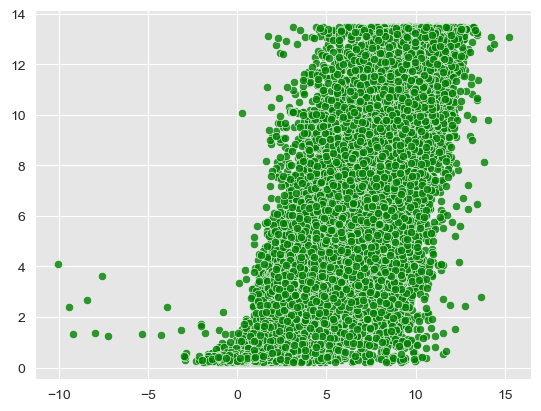

In [176]:
sns.scatterplot(x = Predicted_Values[:, 0], y = Valid_Test_Dataset.values[:, 0], alpha = 0.8, color = "green")
plt.show()

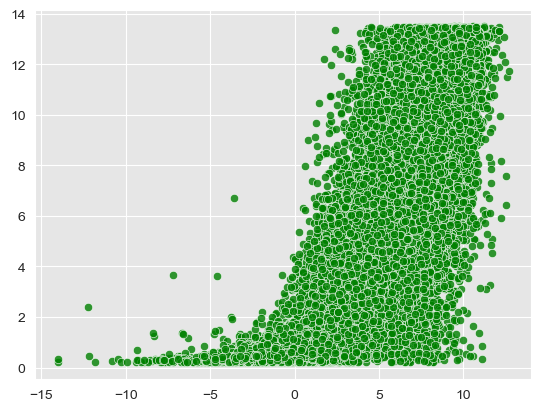

In [48]:
sns.scatterplot(x = Predicted_Values[:, 0], y = Valid_Test_Dataset.values[:, 0], alpha = 0.8, color = "green")
plt.show()

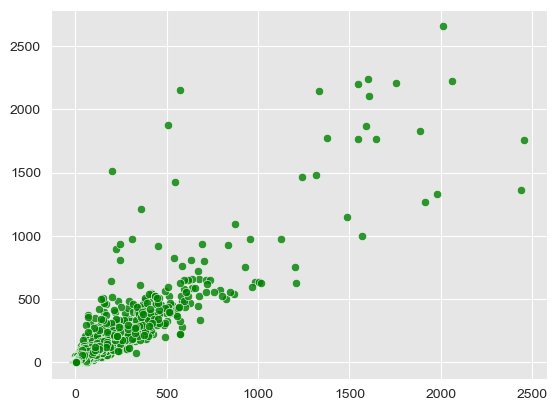

In [173]:
sns.scatterplot(x = Predicted_Values[:, 1], y = Valid_Test_Dataset.values[:, 1], alpha = 0.8, color = "green")
plt.show()

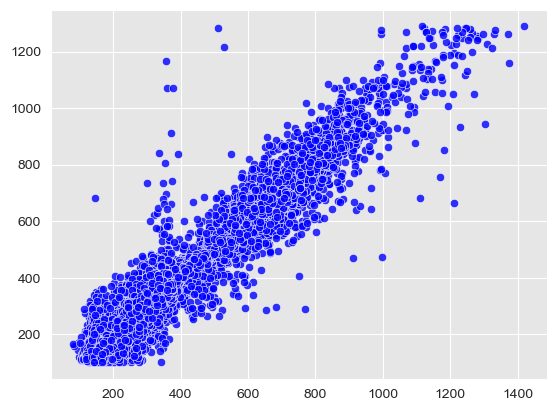

In [49]:
sns.scatterplot(x = Predicted_Values[:, 1], y = Valid_Test_Dataset.values[:, 1], alpha = 0.8, color = "blue")
plt.show()

C:\Users\kdarn\AppData\Local\Temp\ipykernel_27244\792692592.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  im.figure.colorbar(sm)


Text(0, 0.5, 'The predicted Evoledstage_flame')

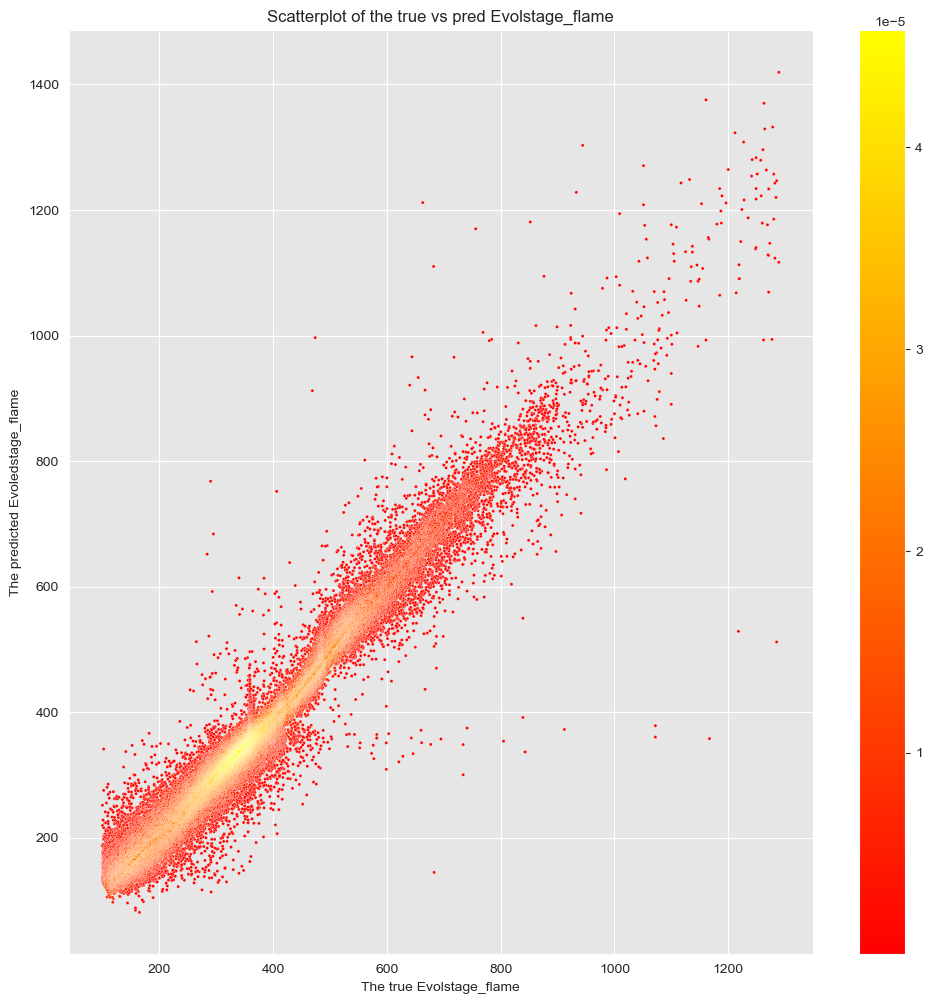

In [54]:
fig, ax = plt.subplots(figsize = (12,12))
x = Valid_Test_Dataset.values[:, 1]
y = Predicted_Values[:, 1]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x = x,
    y = y,
    c = z,
    s = 5,
    cmap = "autumn",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "autumn", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Evolstage_flame")
ax.set_xlabel("The true Evolstage_flame")
ax.set_ylabel("The predicted Evoledstage_flame")

C:\Users\kdarn\AppData\Local\Temp\ipykernel_27244\3155913903.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  im.figure.colorbar(sm)


Text(0, 0.5, 'The predicted age_flame')

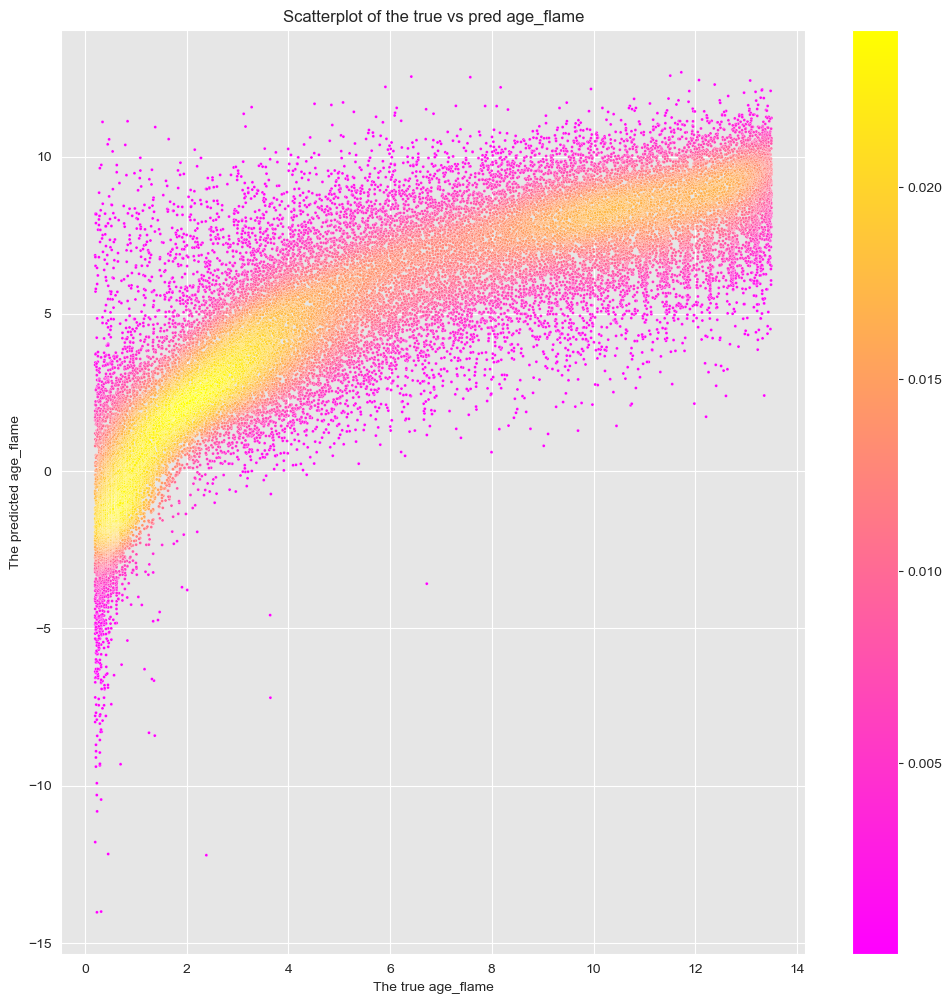

In [56]:
fig, ax = plt.subplots(figsize = (12,12))
x = Valid_Test_Dataset.values[:, 0]
y = Predicted_Values[:, 0]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x = x,
    y = y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred age_flame")
ax.set_xlabel("The true age_flame")
ax.set_ylabel("The predicted age_flame")

C:\Users\kdarn\AppData\Local\Temp\ipykernel_27244\2354788984.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  im.figure.colorbar(sm)


Text(0, 0.5, 'The predicted Lum_flame')

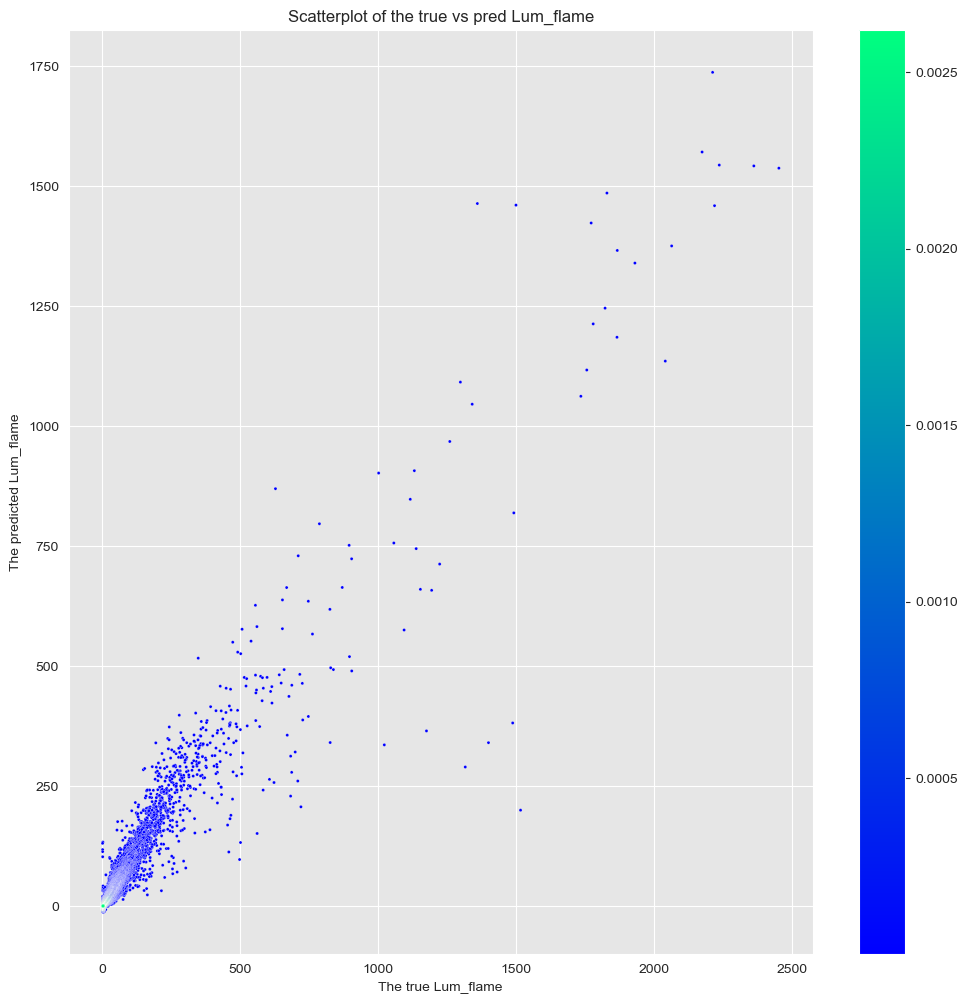

In [59]:
fig, ax = plt.subplots(figsize = (12,12))
x = Valid_Test_Dataset.values[:, 2]
y = Predicted_Values[:, 2]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x = x,
    y = y,
    c = z,
    s = 5,
    cmap = "winter",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "winter", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Lum_flame")
ax.set_xlabel("The true Lum_flame")
ax.set_ylabel("The predicted Lum_flame")

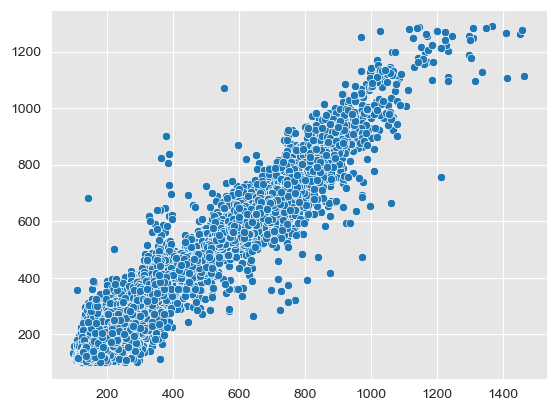

In [175]:
sns.scatterplot(x = Predicted_Values[:, 2], y = Valid_Test_Dataset.values[:, 2])
plt.show()

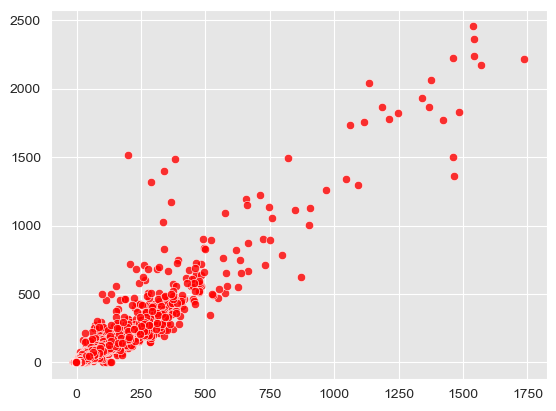

In [50]:
sns.scatterplot(x = Predicted_Values[:, 2], y = Valid_Test_Dataset.values[:, 2], alpha = 0.8, color = "red")
plt.show()